In [1]:
import numpy as np
import torch
import gdown
import os
import zipfile  


if torch.cuda.is_available():
    print(f"✅ GPU is available: {torch.cuda.get_device_name(0)}")
    print(f"🔥 Running on: {torch.device('cuda')}")
else:
    print("❌ GPU not available, using CPU.")


FILE_ID = "19MBh9JIJTxYIPAeO7G5RML5_ddjJ1Cpa"  
ZIP_PATH = "downloaded.zip" 
BASE_PATH = "../data/" 
PIXEL_CLOUD_PATH = os.path.join(BASE_PATH, "pixel_cloud/") 
SKOGSSTYRELSEN = os.path.join(BASE_PATH, "skogsstyrelsen-data/")  

def download_file():
    """Downloads the file from Google Drive if it doesn't exist."""
    if not os.path.exists(ZIP_PATH):
        print(f"📥 Downloading dataset to '{ZIP_PATH}'...")
        gdown.download(f"https://drive.google.com/uc?export=download&id={FILE_ID}", ZIP_PATH, quiet=False)
        print("✅ Download complete!")
    else:
        print(f"✅ File '{ZIP_PATH}' already exists. Skipping download.")

def extract_zip():
    """Extracts the ZIP file into the respective folders and deletes the ZIP file after extraction."""

    if not os.path.exists(ZIP_PATH):
        print(f"❌ Error: '{ZIP_PATH}' not found. Cannot extract.")
        return

    if not zipfile.is_zipfile(ZIP_PATH):
        print("❌ Error: The downloaded file is not a valid ZIP archive.")
        return

    print(f"📂 Extracting '{ZIP_PATH}' into '{BASE_PATH}'...")
    

    os.makedirs(PIXEL_CLOUD_PATH, exist_ok=True)

    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(BASE_PATH)

    print("✅ Extraction complete!")
    os.remove(ZIP_PATH)
    print(f"🗑️ Deleted ZIP file '{ZIP_PATH}' after extraction.")

def list_files():
    """Lists extracted files for verification."""
    print("\n📁 Extracted files in CLOUD_PATH:")
    for root, dirs, files in os.walk(SKOGSSTYRELSEN):
        for file in files:
            print(f" - {os.path.join(root, file)}")

    print("\n📁 Extracted files in PIXEL_CLOUD_PATH:")
    for root, dirs, files in os.walk(PIXEL_CLOUD_PATH):
        for file in files:
            print(f" - {os.path.join(root, file)}")


download_file()
extract_zip()
list_files()



✅ GPU is available: NVIDIA GeForce GTX 1080
🔥 Running on: cuda
📥 Downloading dataset to 'downloaded.zip'...


Downloading...
From: https://drive.google.com/uc?export=download&id=19MBh9JIJTxYIPAeO7G5RML5_ddjJ1Cpa
To: /home/irregular/d7046e_ann_project/notebooks/downloaded.zip
100%|██████████| 4.79M/4.79M [00:00<00:00, 12.5MB/s]


✅ Download complete!
📂 Extracting 'downloaded.zip' into '../data/'...
✅ Extraction complete!
🗑️ Deleted ZIP file 'downloaded.zip' after extraction.

📁 Extracted files in CLOUD_PATH:
 - ../data/skogsstyrelsen-data/skogs_json_val.npy
 - ../data/skogsstyrelsen-data/skogs_gts_val.npy
 - ../data/skogsstyrelsen-data/skogs_gts_test.npy
 - ../data/skogsstyrelsen-data/skogs_names_train.npy
 - ../data/skogsstyrelsen-data/skogs_names_test.npy
 - ../data/skogsstyrelsen-data/skogs_gts_train.npy
 - ../data/skogsstyrelsen-data/skogs_json_test.npy
 - ../data/skogsstyrelsen-data/skogs_json_train.npy
 - ../data/skogsstyrelsen-data/skogs_names_val.npy
 - ../data/skogsstyrelsen-data/2A-netcdfs-cropped-from-nuria/skgs_910d1b98-44c7-ed11-9174-005056a6f472.nc
 - ../data/skogsstyrelsen-data/2A-netcdfs-cropped-from-nuria/skgs_db7d323a-3fc7-ed11-9174-005056a6f472.nc
 - ../data/skogsstyrelsen-data/2A-netcdfs-cropped-from-nuria/skgs_dd360cea-43c7-ed11-9174-005056a6f472.nc
 - ../data/skogsstyrelsen-data/2A-netcdfs

In [8]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import xarray as xr

DATA_PATH = "../data/skogsstyrelsen-data/"
NUMERIC_KEYS = [
    "MedianvardeB2", "MedianvardeB3", "MedianvardeB4", 
    "MedianvardeB11", "MedianvardeB12", "MedelvardeB2",
    "MedelvardeB3", "MedelvardeB4", "MedelvardeB11", "MedelvardeB12",
    "MinX", "MinY", "MaxX", "MaxY"
]

def load_npy_data(split):
    """Loads feature and label data from .npy files based on the split (train, val, test)."""
    features = np.load(os.path.join(DATA_PATH, f"skogs_json_{split}.npy"), allow_pickle=True)
    labels = np.load(os.path.join(DATA_PATH, f"skogs_gts_{split}.npy"), allow_pickle=True)
    file_names = np.load(os.path.join(DATA_PATH, f"skogs_names_{split}.npy"), allow_pickle=True)

    print(f"Loaded {split} data:")
    print(f"Features type: {type(features)}, Labels type: {type(labels)}, File names type: {type(file_names)}")
    print(f"Sample feature (first item): {features[0]}")
    print(f"Type of first feature: {type(features[0])}")

    features = np.array([[f[key] for key in NUMERIC_KEYS] for f in features], dtype=np.float32)
    labels = np.array(labels, dtype=np.int64)  

    print(f"Processed features shape: {features.shape}")
    
    return features, labels, file_names


class SkogsDataset(Dataset):
    def __init__(self, split="train", use_nc=False):
        """
        Custom dataset for Skogsstyrelsen data.
        :param split: "train", "val", or "test"
        :param use_nc: Whether to load additional NetCDF features
        """
        self.features, self.labels, self.file_names = load_npy_data(split)
        self.use_nc = use_nc

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        feature = np.array(self.features[idx], dtype=np.float32) 
        label = int(self.labels[idx])  
        additional_features = None  
        NC = "2A-netcdfs-cropped-from-nuria"

        if self.use_nc:
            nc_file = os.path.join(DATA_PATH, f"{NC}/{self.file_names[idx]}.nc")
            if os.path.exists(nc_file):
                try:
                    with xr.open_dataset(nc_file, engine="netcdf4") as ds:
                        additional_features = ds.to_array().values
                    if isinstance(additional_features, list): 
                        additional_features = np.array(additional_features, dtype=np.float32)
                except Exception as e:
                    print(f"Error loading NetCDF file {nc_file}: {e}")
                    additional_features = None 

        
        if additional_features is None:
            additional_features = np.zeros((1,), dtype=np.float32) 

        return {
            "feature": torch.tensor(feature, dtype=torch.float32),
            "label": torch.tensor(label, dtype=torch.long),
            "additional": torch.tensor(additional_features, dtype=torch.float32)
        }



train_dataset = SkogsDataset("train", use_nc=True)
val_dataset = SkogsDataset("val", use_nc=True)
test_dataset = SkogsDataset("test", use_nc=True)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

batch = next(iter(train_loader))
print(batch["feature"].shape, batch["label"].shape)
if batch["additional"] is not None:
    print(batch["additional"].shape)


Loaded train data:
Features type: <class 'numpy.ndarray'>, Labels type: <class 'numpy.ndarray'>, File names type: <class 'numpy.ndarray'>
Sample feature (first item): {'Bilddatum': '2021-08-01T00:00:00', 'MedianvardeB2': 0.089582354, 'MedianvardeB3': 0.12112157, 'MedianvardeB4': 0.11487451, 'MedianvardeB11': 0.28292942, 'MedianvardeB12': 0.19656117, 'MedelvardeB2': 0.101108, 'MedelvardeB3': 0.13044962, 'MedelvardeB4': 0.122914, 'MedelvardeB11': 0.287079, 'MedelvardeB12': 0.19809, 'MinX': 868605.0, 'MinY': 7342495.0, 'MaxX': 868805.0, 'MaxY': 7342695.0, 'Processingdatum': '2023-03-20T17:49:50', 'ValideringsobjektId': 'a2d32d74-3ec7-ed11-9174-005056a6f472', 'BkId': '73_8', 'MolnDis': '1', 'BildUrl': 'https://geodata.skogsstyrelsen.se/arcgis/rest/services/Swea/Sentinel2_2_0/ImageServer/exportImage?bbox=%28868605%2C+7342495%2C+868805%2C+7342695%29&bboxSR=3006&size=600%2C600&imageSR=3006&time=1627776000000.0&pixelType=UNKNOWN&noDataInterpretation=esriNoDataMatchAny&interpolation=RSP_Bilinea

/tmp/ipykernel_24829/707471859.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(NUMERIC_KEYS, rotation=45, ha="right")
/tmp/ipykernel_24829/707471859.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(NUMERIC_KEYS, rotation=45, ha="right")
/tmp/ipykernel_24829/707471859.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(NUMERIC_KEYS, rotation=45, ha="right")


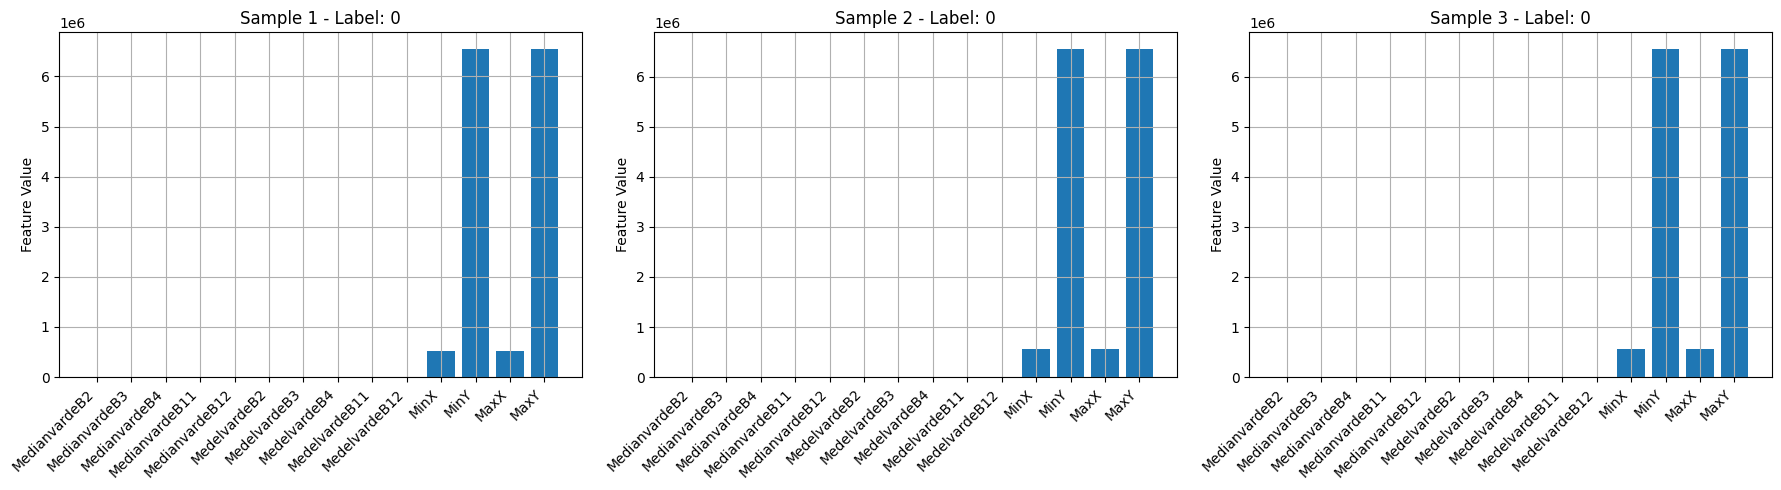

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np


batch = next(iter(train_loader))


features = batch["feature"].numpy()  
labels = batch["label"].numpy() 


num_samples = 3
indices = np.random.choice(features.shape[0], num_samples, replace=False)


NUMERIC_KEYS = [
    "MedianvardeB2", "MedianvardeB3", "MedianvardeB4", 
    "MedianvardeB11", "MedianvardeB12", "MedelvardeB2",
    "MedelvardeB3", "MedelvardeB4", "MedelvardeB11", "MedelvardeB12",
    "MinX", "MinY", "MaxX", "MaxY"
]

fig, axes = plt.subplots(1, num_samples, figsize=(18, 5))

for i, idx in enumerate(indices):
    sample = features[idx]
    label = labels[idx]

    axes[i].bar(NUMERIC_KEYS, sample)
    axes[i].set_title(f"Sample {i+1} - Label: {label}")
    axes[i].set_xticklabels(NUMERIC_KEYS, rotation=45, ha="right")
    axes[i].set_ylabel("Feature Value")
    axes[i].grid(True)

plt.tight_layout()
plt.show()
